# SecM analysis using single cell data
1. pellin *2
2. stroma *2

In [2]:
# load annotation and packages needed
import sys
sys.path.append('/home/hsher/scSecretome')
from scSecretome.secM import *
import scanpy as sc

# read processed, filtered, normalized single cell data.
pellin_cd34 = sc.read('/home/hsher/processed_single_cell_data/pellin_cd34.h5ad')
pellin_lin = sc.read('/home/hsher/processed_single_cell_data/pellin_lin.h5ad')

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [3]:
feizi_annot = feizi_secM()

In [4]:
feizi_annot.head()

,ensgid,gene_name,Subsystem,geneID,Module
0,ENSG00000255587,RAB44,Post-Golgi trafficking,401258,Trafficking
1,ENSG00000135454,B4GALNT1,Golgi glycosylation,2583,Glycosylation
2,ENSG00000125814,NAPB,COPII,63908,Trafficking
3,ENSG00000073969,NSF,COPII,4905,Trafficking
4,ENSG00000135439,AGAP2,Trafficking regulation,116986,Trafficking


In [5]:
feizi_annot.shape

(575, 5)

# differential gene expression?
[Doc](https://scanpy.readthedocs.io/en/stable/api/scanpy.tl.rank_genes_groups.html#scanpy.tl.rank_genes_groups)

In [8]:
def de_analysis(adata, groupby):
    sc.tl.rank_genes_groups(adata, groupby = groupby)
    sc.tl.filter_rank_genes_groups(adata, min_fold_change=3)

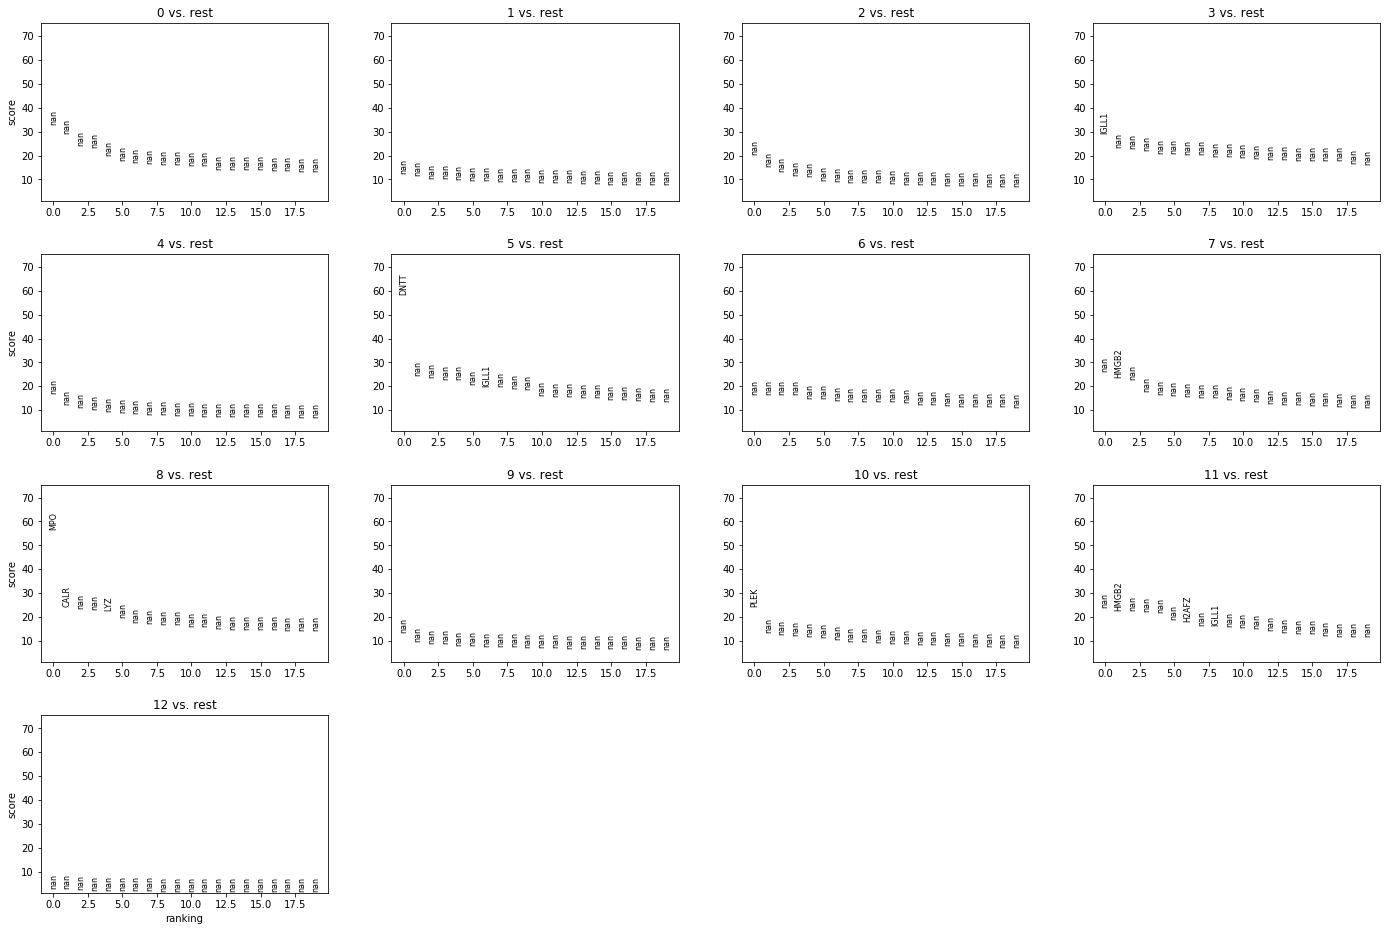

categories: 0, 1, 2, etc.
var_group_labels: 3, 5, 7, etc.


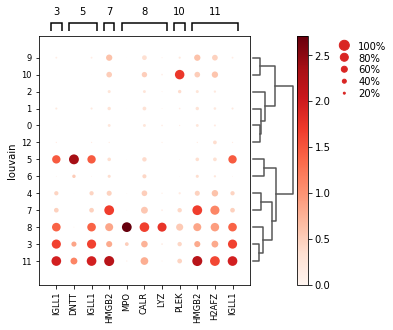

In [9]:
de_analysis(pellin_cd34, 'louvain')

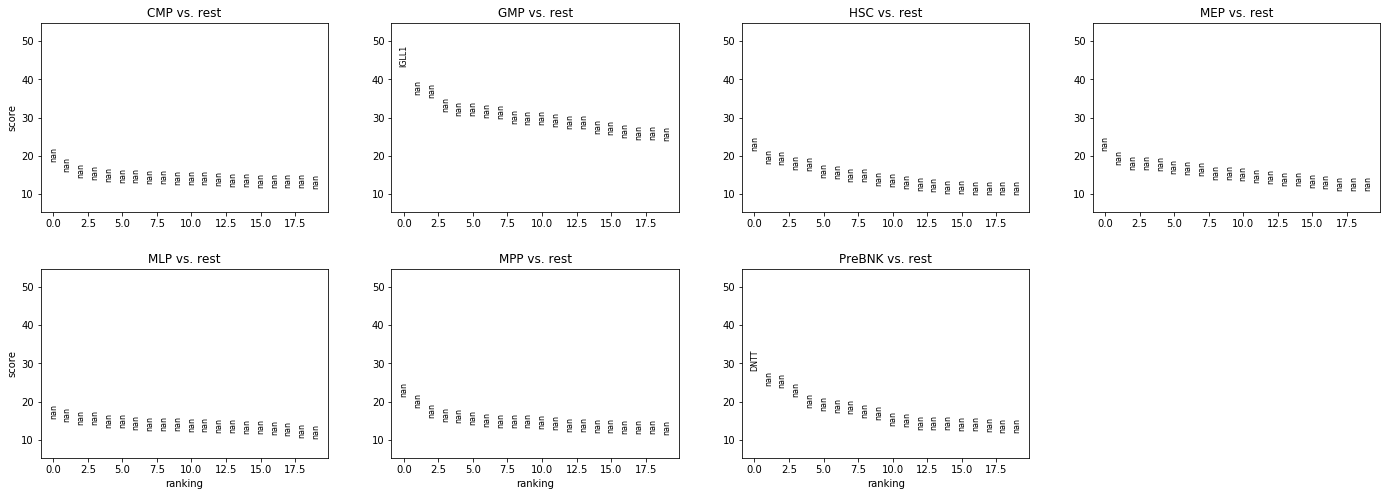

categories: CMP, GMP, HSC, etc.
var_group_labels: GMP, PreBNK


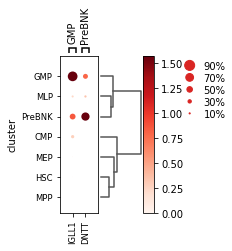

In [10]:
sc.tl.rank_genes_groups(pellin_cd34, groupby = 'cluster')
sc.tl.filter_rank_genes_groups(pellin_cd34, min_fold_change=3)
# visualize results
sc.pl.rank_genes_groups(pellin_cd34, key='rank_genes_groups_filtered', method='wilcoxon')
# visualize results using dotplot
sc.pl.rank_genes_groups_dotplot(pellin_cd34, key='rank_genes_groups_filtered')

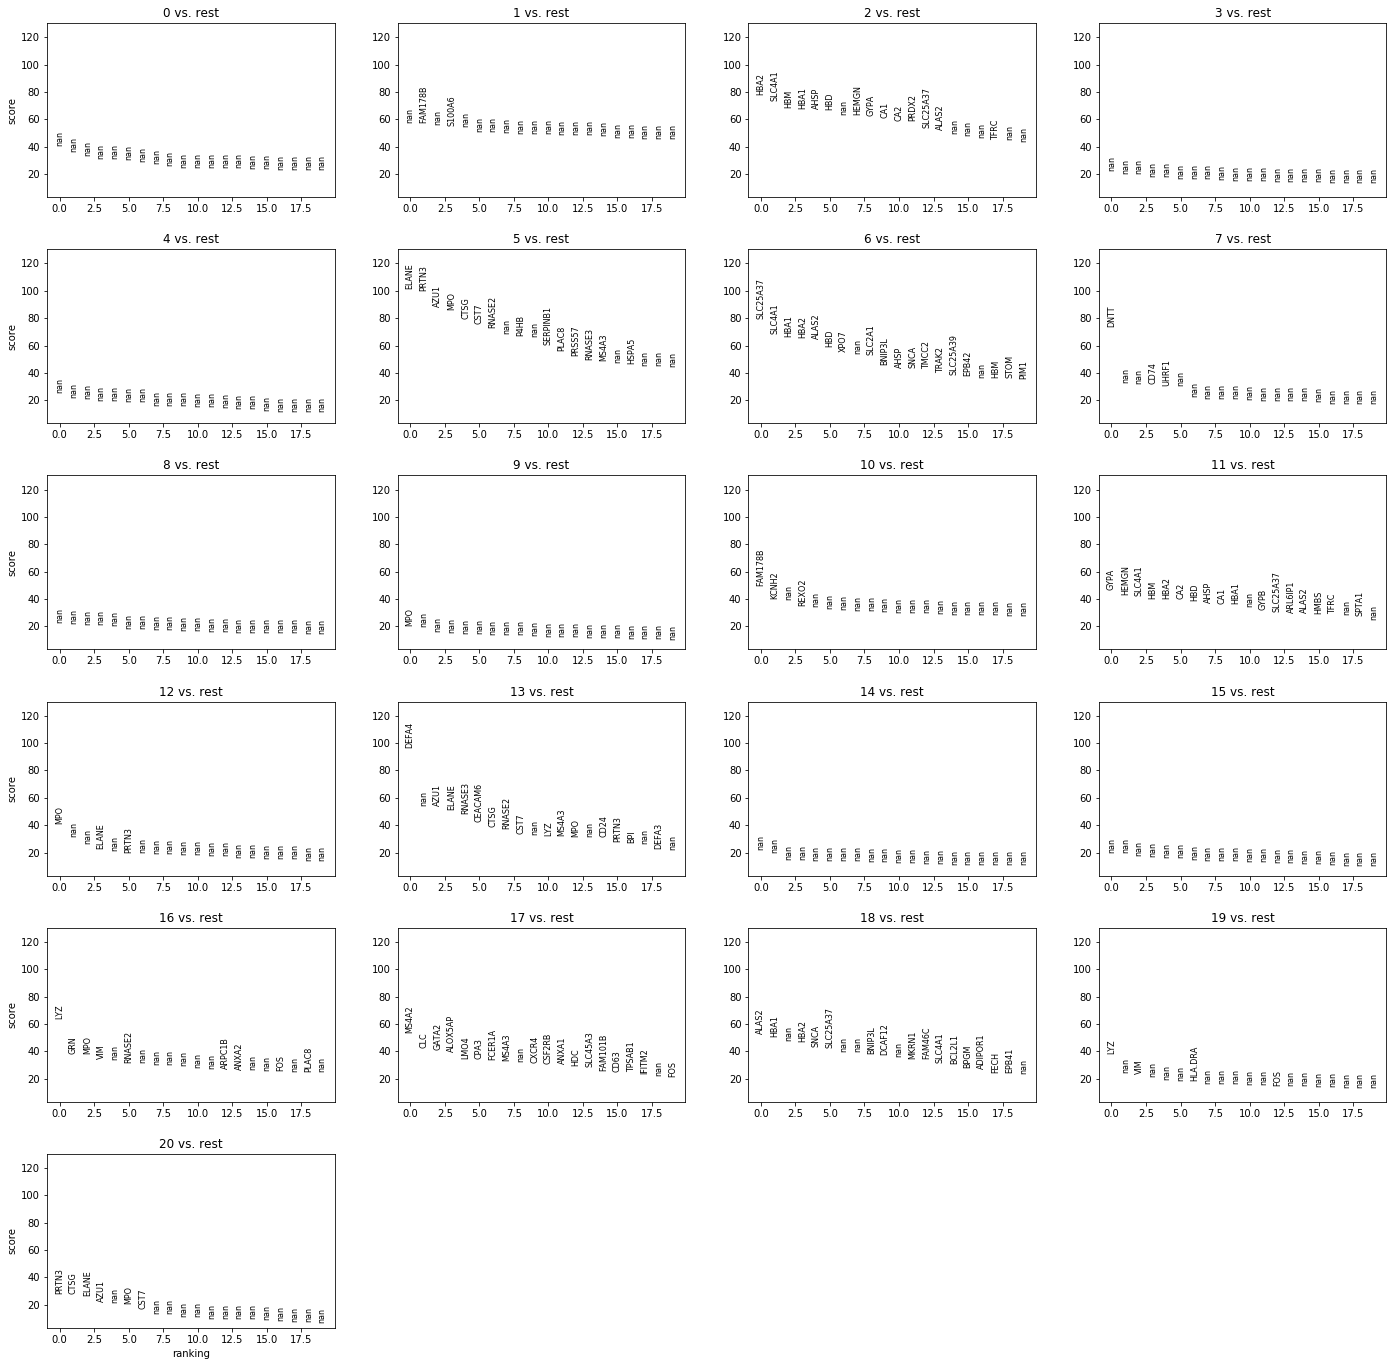

categories: 0, 1, 2, etc.
var_group_labels: 1, 2, 5, etc.


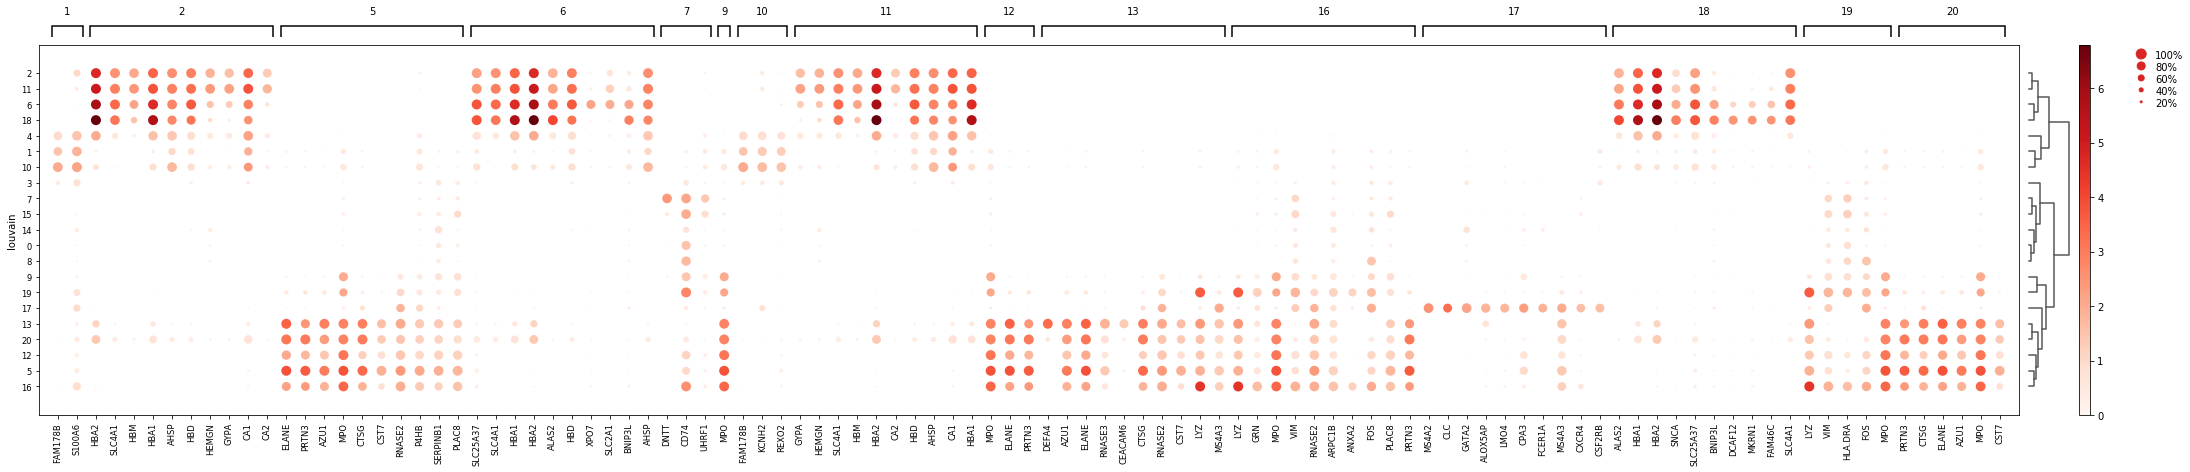

In [11]:
sc.tl.rank_genes_groups(pellin_lin, groupby = 'louvain')
sc.tl.filter_rank_genes_groups(pellin_lin, min_fold_change=3)
# visualize results
sc.pl.rank_genes_groups(pellin_lin, key='rank_genes_groups_filtered')
# visualize results using dotplot
sc.pl.rank_genes_groups_dotplot(pellin_lin, key='rank_genes_groups_filtered')

In [12]:
def all_de_genes(adata):
    '''
    return a list of all differentially expressed gene
    '''
    all_genes = set()
    for gene_set in adata.uns['rank_genes_groups']['names']:
        
        all_genes = all_genes.union(set(gene_set.tolist()))
    return(all_genes)

In [13]:
de_lin = all_de_genes(pellin_lin)

In [14]:
de_cd34 = all_de_genes(pellin_cd34)

In [15]:
len(de_lin) 
len(de_cd34)

490

# See how many de genes are in SecM

In [16]:
de_secM_lin = de_lin.intersection(set(feizi_annot['gene_name']))

In [17]:
de_secM_cd34 = de_cd34.intersection(set(feizi_annot['gene_name']))

In [18]:
len(de_secM_lin)

40

In [19]:
len(de_secM_cd34)

13

In [20]:
de_secM_lin.intersection(de_secM_cd34)

{'CALR',
 'DAD1',
 'HSP90AB1',
 'HSP90B1',
 'HSPA8',
 'PPIA',
 'SEC61B',
 'TMED10',
 'UBE2J1'}

In [21]:
de_secM_all = de_secM_lin.union(de_secM_cd34)

In [22]:
grouped_de = feizi_annot.loc[feizi_annot['gene_name'].isin(de_secM_all)].groupby(by = ['Module', 'Subsystem'])

In [23]:
grouped_de.count()

ensgid  gene_name  geneID
Module           Subsystem                                        
Capacity Control ERAD                         5          5       5
                 UPR                          3          3       3
Folding          Protein folding             12         12      12
                 Translocation                8          8       8
Glycosylation    ER glycosylation             1          1       1
                 Golgi glycosylation          4          4       4
Trafficking      COPI                         2          2       2
                 COPII                        2          2       2
                 Post-Golgi trafficking       6          6       6
                 Trafficking regulation       1          1       1

In [24]:
var_group_label = []
var_group_location = []
gene_list = []
pos = 0
for key, item in grouped_de['gene_name']:
    # annotation
    var_group_label.append(str(key))
    
    # annotation group location
    start = pos
    end = pos + len(item) - 1
    var_group_location.append((start, end))
    
    # append gene list
    gene_list = gene_list + item.tolist()
    
    # next!
    pos = end + 1
    

In [25]:
len(item)

1

categories: 0, 1, 2, etc.
var_group_labels: ('Capacity Control', 'ERAD'), ('Capacity Control', 'UPR'), ('Folding', 'Protein folding'), etc.


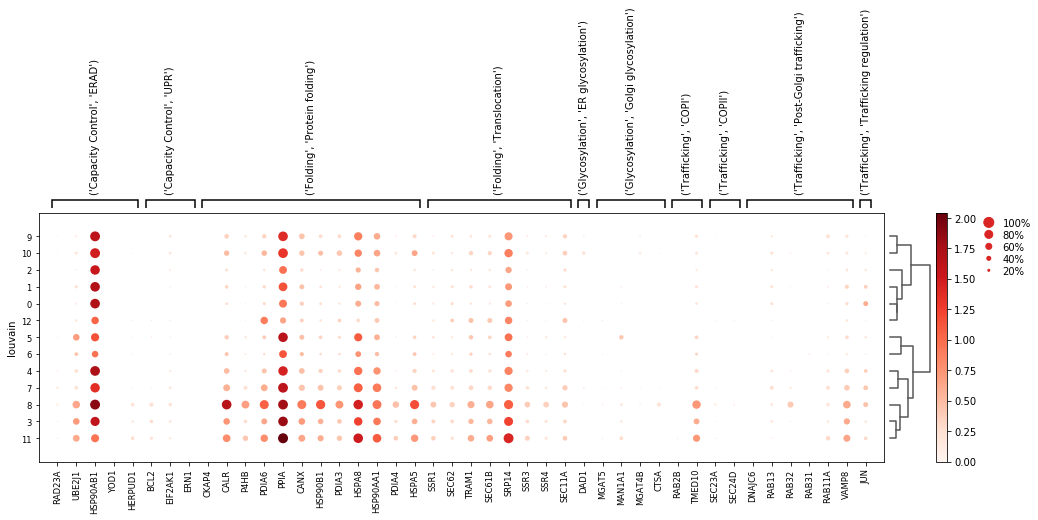

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[15.399999999999999, 0.8, 0.2, 0.5, 0.25])

In [26]:
sc.pl.dotplot(pellin_cd34, gene_list, groupby='louvain', var_group_positions=var_group_location,
              var_group_labels=var_group_label,  dendrogram='dendrogram_louvain')

In [27]:
cd34_paths = [('MEP-Meg', [0,2,10]),
         ('Meg-Erythro', [0,2,9,7]),
         ('CMP-gran', [0,1,4,8]),
         ('CMP-NK', [0,1,4,7]),
         ('CMP-Ly', [0,1,4,7])
        ]
def psuedotime_de_genes(gene_names, paths, adata):
    # pseudotime analysis of transcription factor change


    # plotting
    import matplotlib.pyplot as plt
    _, axs = plt.subplots(ncols=len(paths), figsize=(12, 0.25*(len(gene_list)+2)), gridspec_kw={'wspace': 0.05, 'left': 0.12})
    plt.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
    for ipath, (descr, path) in enumerate(paths):
        _, data = sc.pl.paga_path(
            adata, path, gene_names,
            show_node_names=False,
            ax=axs[ipath],
            ytick_fontsize=12,
            left_margin=0.15,
            n_avg=50,
            annotations=['dpt_pseudotime'],
            show_yticks=True if ipath==0 else False,
            show_colorbar=False,
            color_map='coolwarm',
            color_maps_annotations={'distance': 'viridis'},
            title='{} path'.format(descr),
            return_data=True,
            show=False)
    

    plt.show()
    return(data)

/home/hsher/miniconda3/envs/scanpy/lib/python3.6/site-packages/anndata/core/anndata.py:299: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


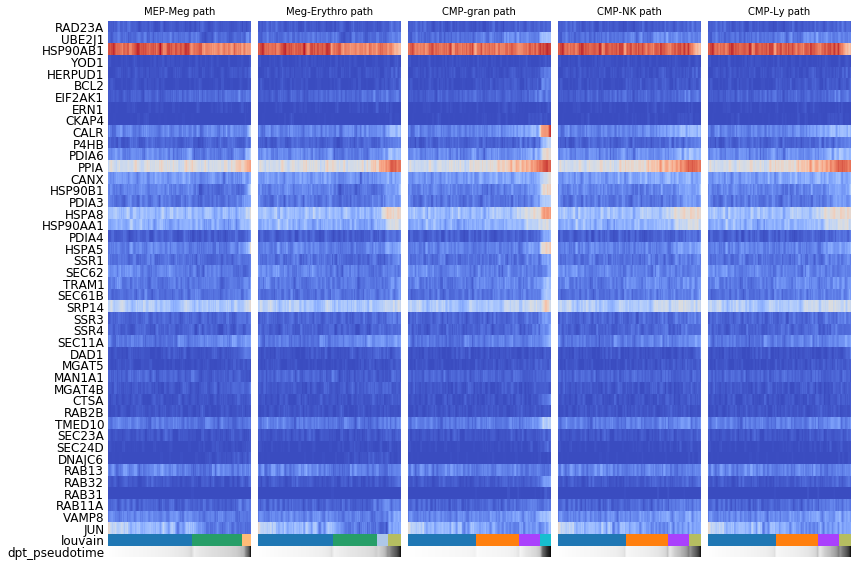

In [28]:
pseudotime_cd34 = psuedotime_de_genes(gene_list, cd34_paths, pellin_cd34)

categories: 0, 1, 2, etc.
var_group_labels: ('Capacity Control', 'ERAD'), ('Capacity Control', 'UPR'), ('Folding', 'Protein folding'), etc.


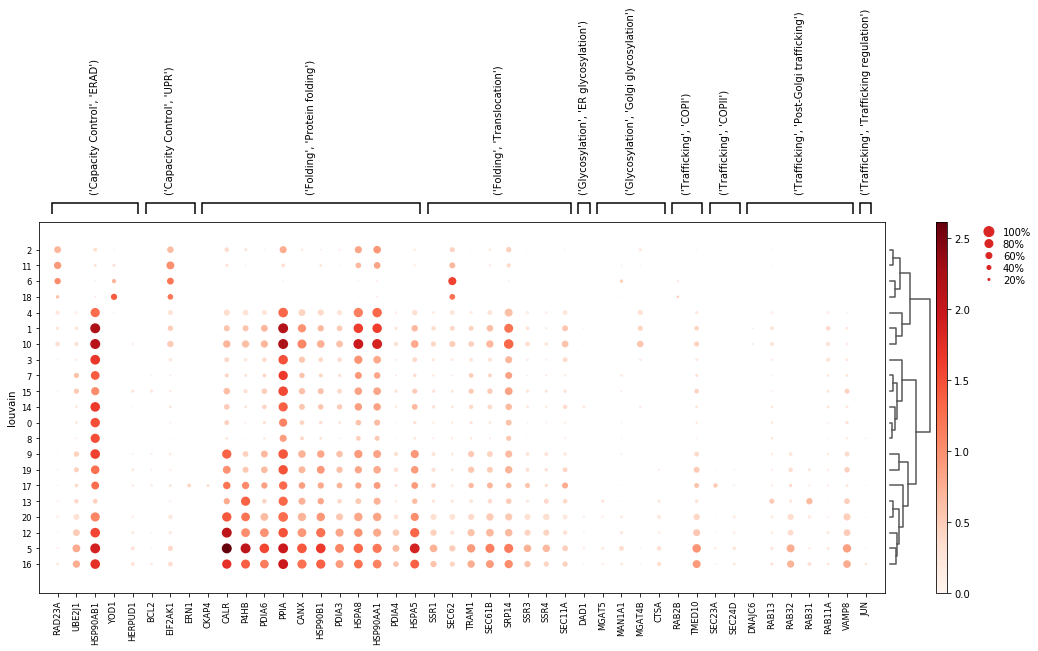

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[15.399999999999999, 0.8, 0.2, 0.5, 0.25])

In [29]:
sc.pl.dotplot(pellin_lin, gene_list, groupby='louvain', var_group_positions=var_group_location,
              var_group_labels=var_group_label,  dendrogram='dendrogram_louvain')

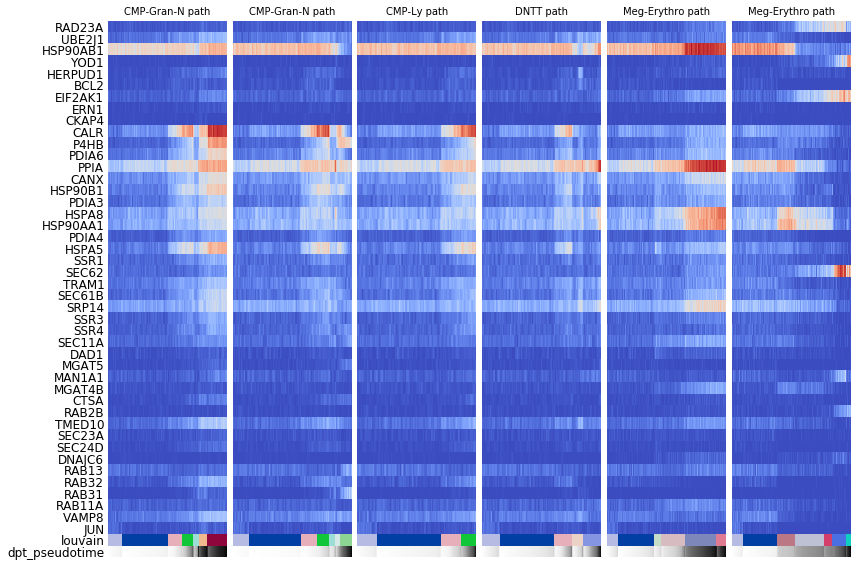

In [30]:
lin_paths = [('CMP-Gran-N', [8,0,9,12,19,16,5]),
         ('CMP-Gran-N', [8,0,9,12,19,20,13]),
         ('CMP-Ly', [8,0,9,12]),
         ('DNTT', [8,0,9,15,7]),
         ('Meg-Erythro', [8,0,14,3,1,10]),
         ('Meg-Erythro', [8,0,4,2,11,6,18])
        ] 
pseudotime_lin = psuedotime_de_genes(gene_list, lin_paths, pellin_lin)

In [31]:
gly, bi_gly = glyco_curation()

In [32]:
gly['Process'].value_counts()

N-glycan                 42
O-glycan_notMucin        36
O-glycan_Mucin           35
lacto_neolacto series    27
heparan sulfate          24
GPI-anchor               23
additional               21
chondroitin sulfate      19
keratan sulfate          16
ganglio series           13
globo series             10
SLC_transporter          10
terminal modification     5
sphingolipid              4
Hyaluronic acid           3
Others                    2
unassigned                1
WT                        1
Name: Process, dtype: int64

In [33]:
gly['Gene Symbol (Human)']

0       A(ABO)
1      A3GALT2
2       A4GALT
3        A4GNT
4         ALG1
        ...   
287     XXYLT1
288      XYLT1
289      XYLT1
290      XYLT2
291      XYLT2
Name: Gene Symbol (Human), Length: 292, dtype: object

In [34]:
grouped_gly = gly.loc[gly['Gene Symbol (Human)'].isin(de_secM_all)].groupby(by = ['Process'])

In [35]:
grouped_gly.count()

,GROUP,uid,Gene Symbol (Human),Mapped Process,Process Score
Process,,,,,
N-glycan,2,2,2,2,2


In [36]:
for key, item in grouped_gly['Gene Symbol (Human)']:
    print(item)

188    MGAT4B
191     MGAT5
Name: Gene Symbol (Human), dtype: object


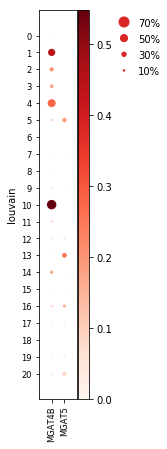

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[0.7, 0, 0.2, 0.5, 0.25])

In [37]:
sc.pl.dotplot(pellin_lin, item, groupby='louvain')

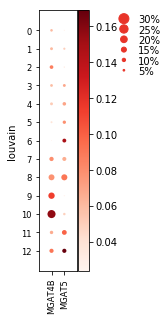

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[0.7, 0, 0.2, 0.5, 0.25])

In [38]:
sc.pl.dotplot(pellin_cd34, item, groupby='louvain')

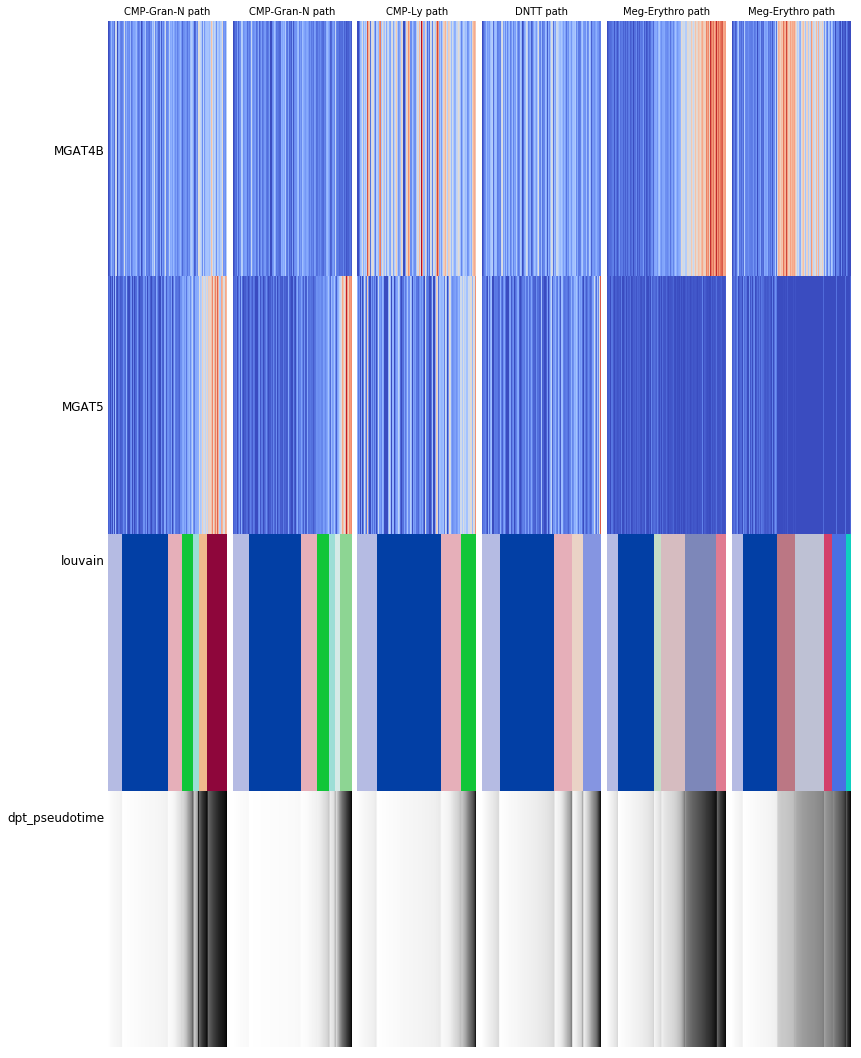

In [39]:
pseudotime_lin = psuedotime_de_genes(item, lin_paths, pellin_lin)

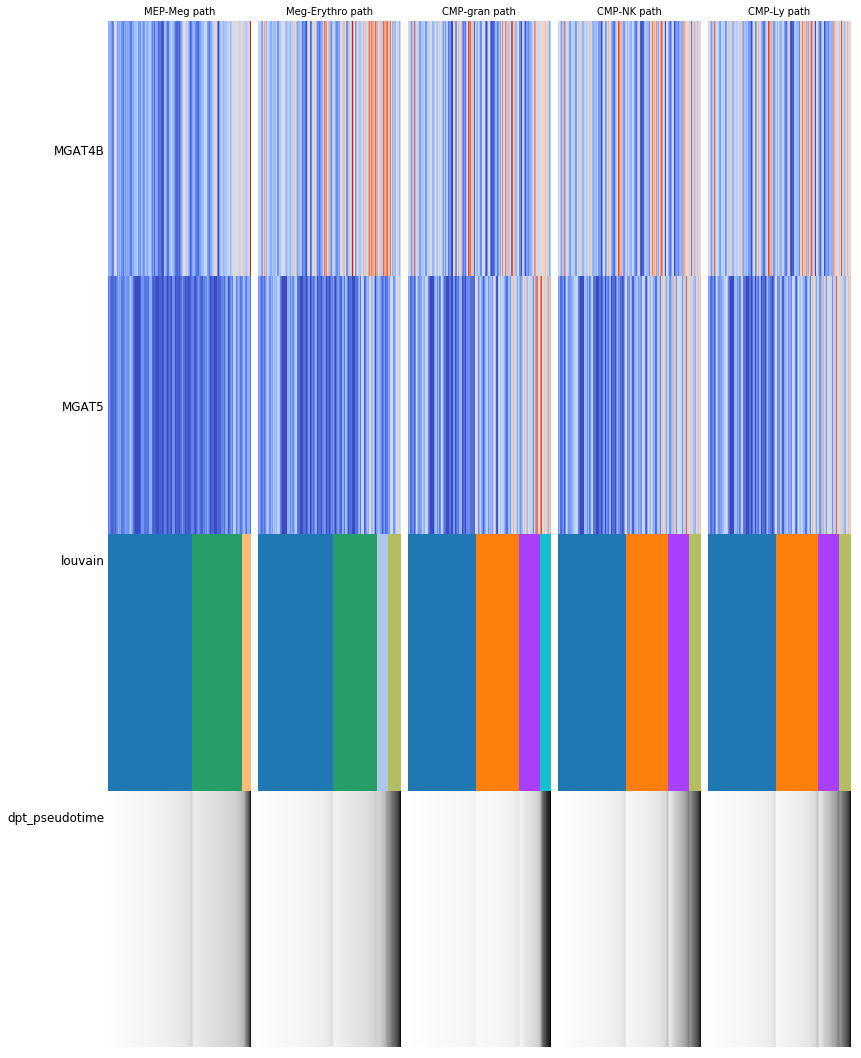

In [40]:
pseudotime_cd34 = psuedotime_de_genes(item, cd34_paths, pellin_cd34)

# Stroma dataset

In [41]:
tikhonova = sc.read('/home/hsher/processed_single_cell_data/tikhonova.h5ad')
wolock = sc.read('/home/hsher/processed_single_cell_data/wolock.h5ad')
bary = sc.read('/home/hsher/processed_single_cell_data/baryawno.h5ad')

In [42]:
bary.raw = bary

In [43]:
de_analysis(tikhonova, 'louvain')
de_analysis(wolock, 'louvain')
de_analysis(bary, 'louvain')

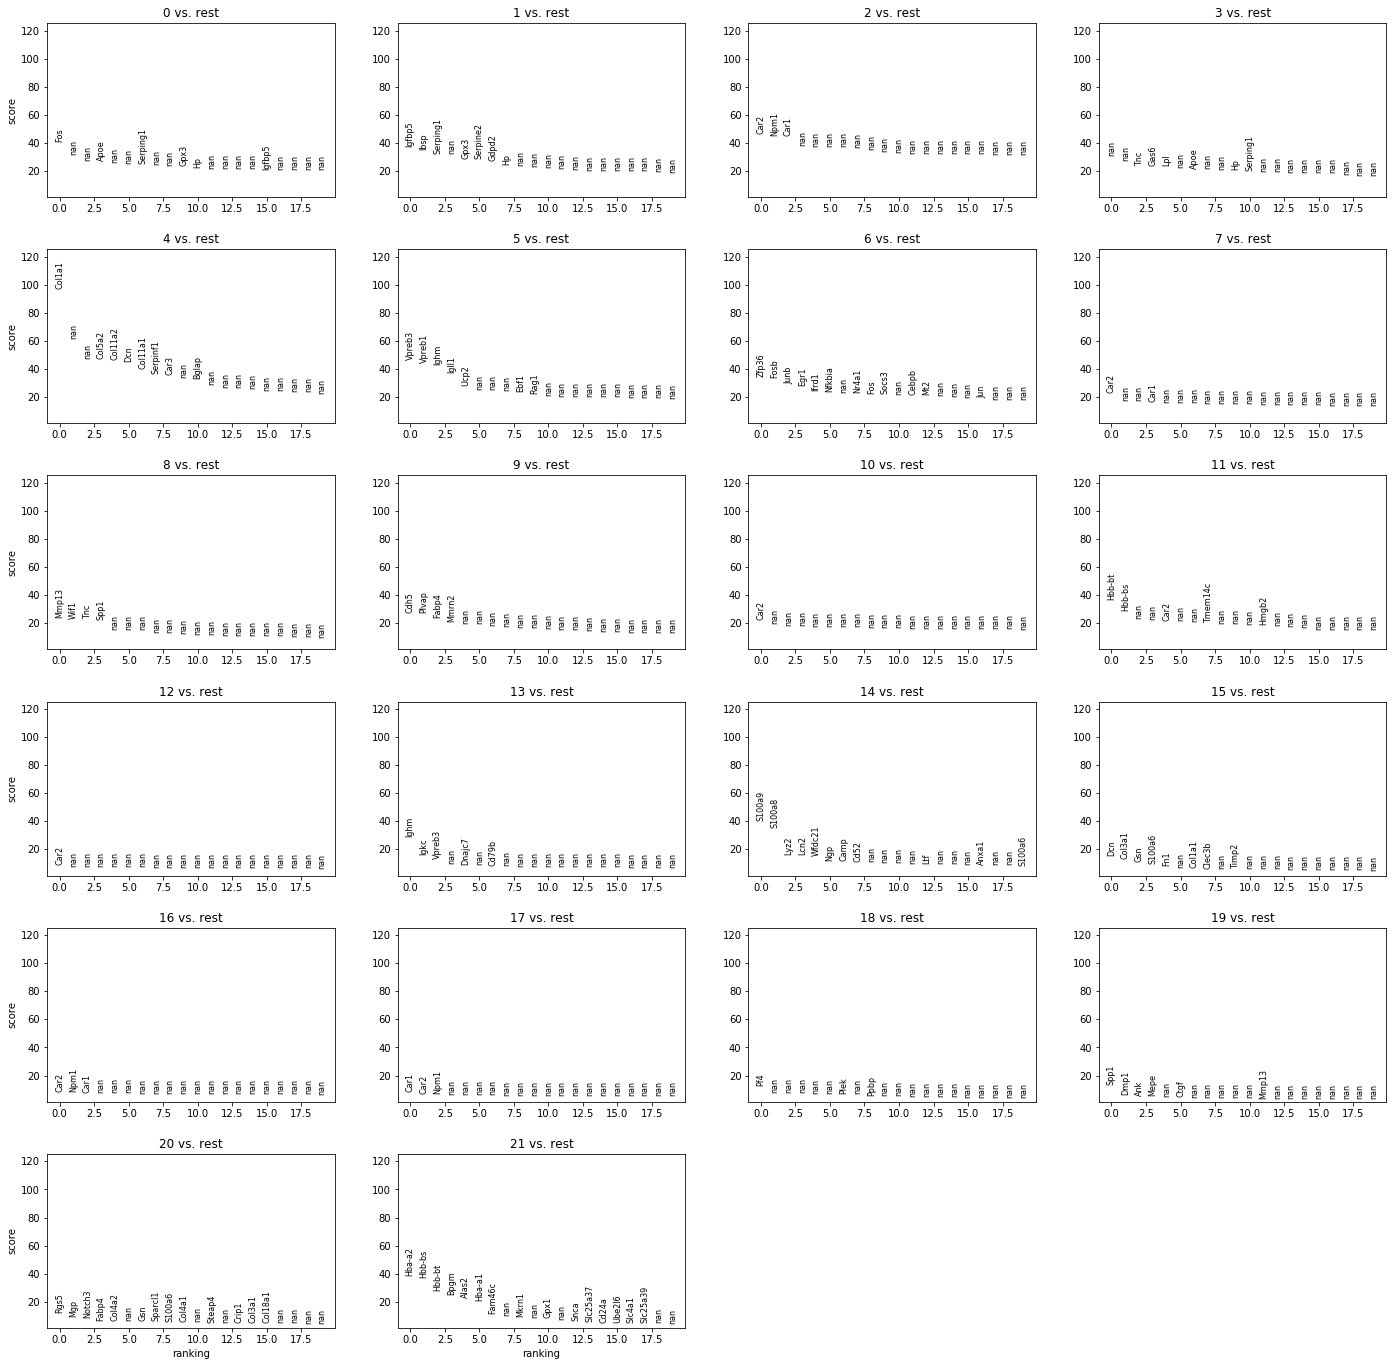

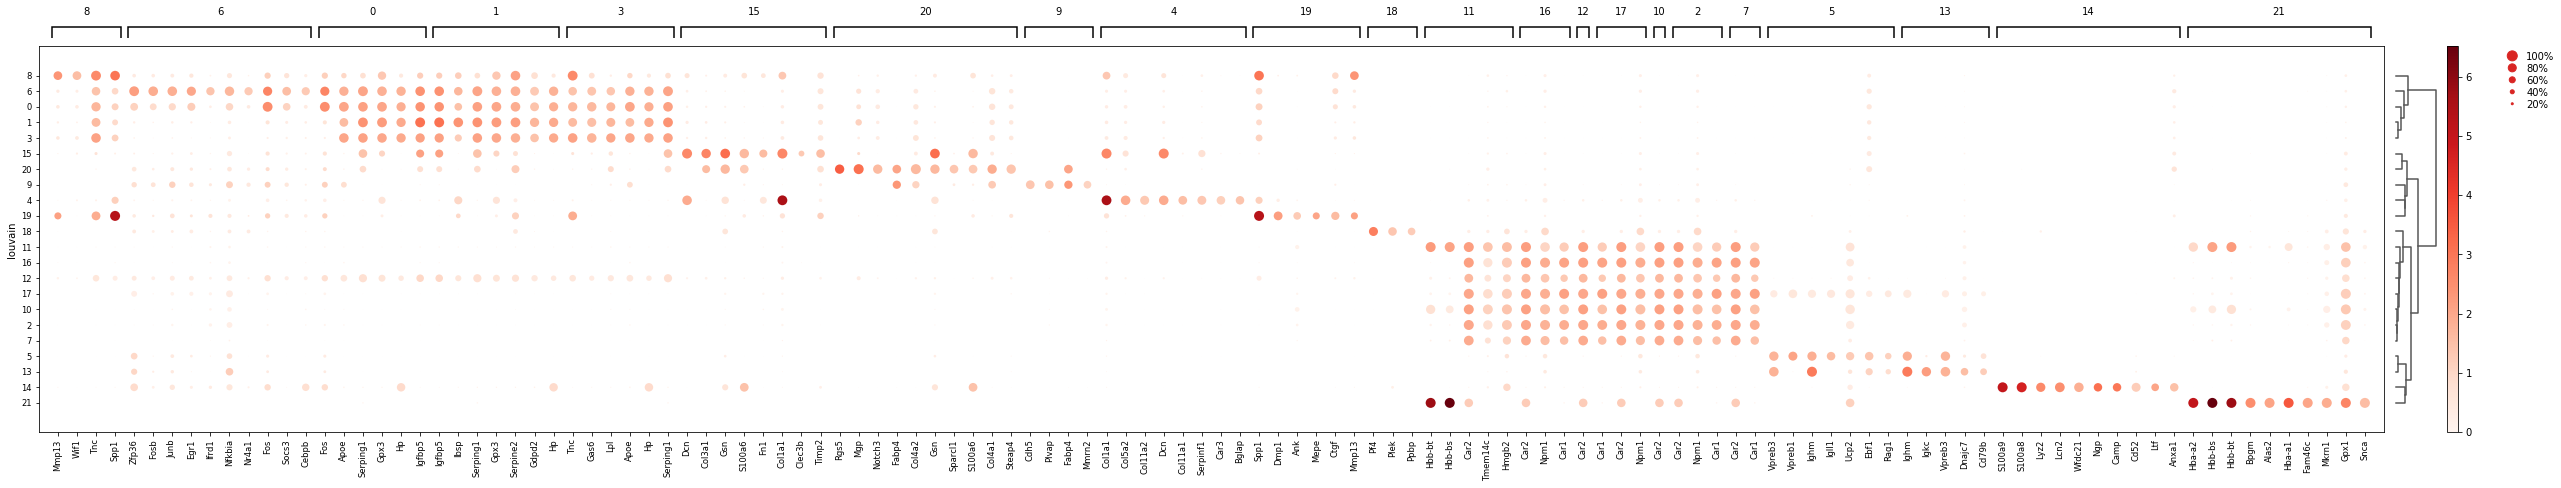

In [44]:
sc.pl.rank_genes_groups(wolock, key='rank_genes_groups_filtered')
# visualize results using dotplot
sc.pl.rank_genes_groups_dotplot(wolock, key='rank_genes_groups_filtered')